## Introduction to Modeling with Python

Now that we have seen some examples of modeling and using Python for modeling, we wanted to give you a chance to try your hand!

To that goal, we choose a well structured problem with plenty of resources online to help you along the way. That problem is predicting housing prices and is hosted on Kaggle:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

First, make sure you are signed up on Kaggle and then download the data:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

The data includes both testing and training sets as well as a sample submission file. 

Your goal is the predict the sales price for each house where root mean squared error is the evaluation metric. To get some ideas on where to start, feel free to check out Kaggle Kernels:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels

And the discussion board:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion

Again - the goal of this homework is to get you exposed to modeling with Python. Feel free to use online resources to help guide you, but we expect original thought as well. Our hope is by the end of this homework you will feel comfortable exploring data in Python and building models to make predictions. Also please submit your test results to Kaggle and let us know your ranking and score!


### Grading

This homework is due **Feb. 20, 2018 by 3:00pm Utah time.** By that time, you need to have committed all your code to your github and submitted a link to your work to the TA. We can see on your Github account when you last committed code. :)

Rubric:

* Code Quality - 10%
* Storytelling - 10%
* Result on Kaggle - 5%
* Describing, Cleaning, and Visualizing data - 25%
* Modeling - 50%

More specifically, for modeling we will look for: 

* Model Selection: Did you try multiple models? Why did you choose these models? How do they work? What are they assumptions? And how did you test/account for them? How did you select hyper-parameters?
* Model interpretation: What do the model results tell you? Which variables are important? High bias or variance and how did you / could you fix this? How confident are you in your results? 
* Model usefulness: Do you think your final model was useful? If so, how would you recommend using it? Convince us, that if we were a company, we would feel comfortable using your model with our users. Think about edge cases as well - are there certain areas that the model performs poorly on? Best on? How would you handle these cases, if say Zillow wanted to leverage your model realizing that bad recommendations on sale prices would hurt customer trust and your brand. This section also falls into the storytelling aspect of the grading.

In [48]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
plt.style.use("seaborn")
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,8] # sets plot size

### Data Cleaning

First, I will read in the test and train csv files from Kaggle and look at their shapes to get an idea of what the data is like. 

In [2]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [5]:
test.shape

(1459, 80)

In [6]:
train.shape

(1460, 81)

There are a lot of features in this housing data, so it will take a fair amount of inspection and cleaning to get it in working order.

In [24]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Drop Variables**

After looping through the dataframe and printing out the normalized value counts of each column, I was able to identify which columns were worth keeping based on categorical distribution skewness. The columns with a category containing more than 60% of the data will be dropped because categorical skewness can cause bias in modeling and lead to imprecise estimates.

In [25]:
# dropped array stores skewed categorical columns to be dropped
dropped = []

for i in train:
    if train[i].value_counts(normalize=True, dropna=False).iloc[0] > .6:
            dropped.append(i)

In [26]:
print("Number of columns to be dropped: {}".format(len(dropped)))

Number of columns to be dropped: 40


In [27]:
# drops variables that do not meet the 60% threshhold
train.drop(dropped, axis=1, inplace=True)

**Additional Columns to Drop**

The following columns were dropped for reasons other than not meeting the categorical skewness threshold:
- 'Exterior2nd': The variable Exterior1st provides a sufficient metric for type of home exterior material
- 'GarageType': Since this variable has a lot of categories and there are many other descriptive "garage" variables, it does not make sense to keep
- 'MSSubClass': Based on the normalized categorical distribution of this variable, it is nearly colinear with 'HouseStyle' + 'YearBuilt' and therefore provides no additional predictive power.
- 'Neighborhood' is unlikely to be useful, since houses within the same neighborhood generally have similar qualities.
- 'Id' is an arbitrary identifier and has no predictive power

In [28]:
# Drops other variables that do not add predictive power
train.drop(["Exterior2nd", "GarageType", "MSSubClass", "Neighborhood", "Id"], axis=1, inplace=True)

The code below appends the 'dropped' array in order to keep track of which columns are used and which are not. This will simplify matters when it comes time to clean the test set for final predictions.

In [29]:
# Appends the array of dropped variables
dropped.extend(["Exterior2nd", "GarageType", "MSSubClass", "Neighborhood", "Id"])

**Imputing Null Values**

The following loop creates arrays to keep track of the categorical and non-categorical columns with null values in order to properly impute missing values.

In [31]:
Nulls_cat = []
Nulls_noncat = []

print("Column\t\t", "Nulls\t", "dtype\t")
for i in train:
    if train[i].dtype=='object':
        if train[i].isnull().sum() != 0:
            print(i,"\t", train[i].isnull().sum(),"\t", train[i].dtype)
            # Prints sum of null values for categorical columns containing nulls
            Nulls_cat.append(i)
    else:
        if train[i].isnull().sum() != 0:
            print(i,"\t", train[i].isnull().sum(),"\t", train[i].dtype)
            # Prints sum of null values for numerical columns containing nulls
            Nulls_noncat.append(i)

Column		 Nulls	 dtype	
LotFrontage 	 259 	 float64
MasVnrType 	 8 	 object
MasVnrArea 	 8 	 float64
BsmtQual 	 37 	 object
BsmtFinType1 	 37 	 object
FireplaceQu 	 690 	 object
GarageYrBlt 	 81 	 float64
GarageFinish 	 81 	 object


In [32]:
# Fills the numeric columns with null values (contained in the array "Nulls") with the column averages
train = train.fillna(train[Nulls_noncat].mean()).round()

For verification, we can check if any numeric columns in train have null values. We should expect a value of 5. The remaining object columns containing null values will be handled in the following section.

In [33]:
# Counts the number of columns with null values
train.isnull().any().sum()

5

Now that the numeric columns have been fully cleaned, we can take a quick look at how some of the more relevant features correlate with our dependent variable. This will provide a usefull illustration of the data and indicate the top ten correlated features.

Text(0.5,1,'Top Ten Feature Correlations with SalePrice')

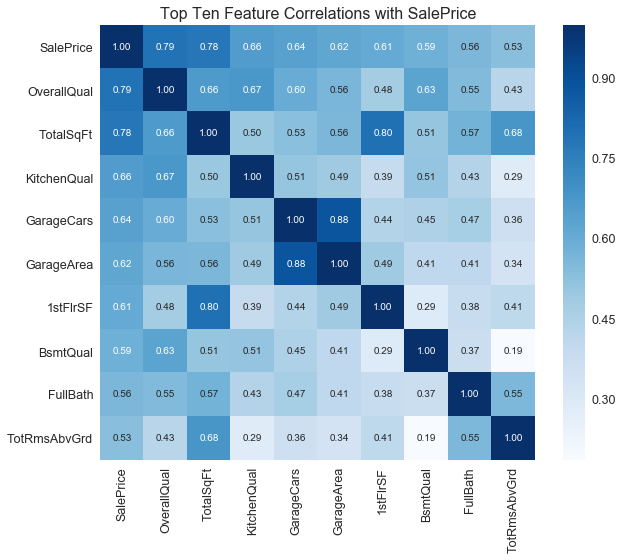

In [49]:
corrmat = train.corr() # Calculates correlations for all features
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index # Selects the 10 features most correlated with SalePrice
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
heatmap = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values, cmap="Blues")
plt.title("Top Ten Feature Correlations with SalePrice", fontsize=16)

Next, there are still many categorical features to handle. Based on the feature values and characteristics, for some I will use one-hot encoding and for others I will use label encoding where reasonable. 

**Columns to transform:**
- 'Exterior1st' get dummies for top 4 categories since they make up over 80% of the data
- 'HouseStyle' get dummies for 1 story and 2 story houses
- 'GarageFinish' encode as 1 for finished and 0 for unfinished
- 'Foundation' get dummies for 'PConc' and 'CBlock' and consolidate the other variables to 'other' category since they make up +87% of the data.
- 'MasVnrType' get dummies after consolidating 'brick' categories
- 'BsmtQual', 'HeatingQC', 'KitchenQual', and 'FireplaceQu' change to numeric scale
- 'BsmtFinType1' encode as a numeric quality scale

In [39]:
# Reduces 'Exterior1st' column to just have 5 categories: 'VinylSd', 'HdBoard', 'MetalSd', 'Wd Sdng', and 'Other'
train.Exterior1st = train.Exterior1st.apply(lambda x: x if str(x)[0]=="V" or str(x)[0]=="H" or str(x)[0]=="M" 
                                           or str(x)[0:5]=="Wd Sd" else "Other")
# Creates dummies for new Exterior1st column
train = pd.get_dummies(train, columns=["Exterior1st"])

In [40]:
# Since 80% of the values are either 1 or 2 story houses, the other values are extraneous and uninformative
# Hence, 'HouseStyle_1' essentially serves as an indicator for 1 story or more than 1 story (1.5, 2, 2.5, & split lvl)
train["HStyle_1LvL"] = np.where(train.HouseStyle.str.contains("1Story"), 1, 0)
train.drop("HouseStyle", axis=1, inplace=True)

In [41]:
# Encodes 'GarageFinish' column to an indicator for houses with finished garages instead of categories
train.GarageFinish = train.GarageFinish.apply(lambda x: 1 if str(x)[0:3] == "Fin" else 0)

In [42]:
# Consolidates 'BrkFace' and 'BrkCmn' into one 'Brick' category
train.MasVnrType = train.MasVnrType.apply(lambda x: x if str(x)[0:3] != "Brk" else "Brick")

# Creates dummy variables for 'MasVnrType'
train = pd.get_dummies(train, columns=["MasVnrType"])

In [43]:
# Reduces 'Foundation' column to just have 3 categories: 'PConc', 'CBrick', and 'Other'
train.Foundation = train.Foundation.apply(lambda x: x if str(x)[0] == "P" or str(x)[0] == "C" else "Other")

# Creates dummy variables for each Neighborhood
train = pd.get_dummies(train, columns=["Foundation"])

In [44]:
# Dictionary assigning numeric values to categorical columns with a "poor" to "excellent"
num_assignments = {"BsmtQual": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, np.nan:0},
                  "HeatingQC": {"Ex":4, "Gd":3, "TA":2, "Fa":1, "Po":0},
                  "KitchenQual": {"Ex":4, "Gd":3, "TA":2, "Fa":1, "Po":0},
                  "FireplaceQu": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, np.nan:0},
                  "BsmtFinType1": {"GLQ":6, "ALQ":5, "BLQ":4, "Rec":3, "LwQ":2, "Unf":1, np.nan:0}}
# Note: For 'BsmtQual', FireplaceQu', and 'BsmtFinType1' the null values are set to zero as their own category. 
        # This makes sense in context because the categories are measuring feature quality; Hence, if a feature is not
        # reported it cannot be characterized.
# Uses the 'num_assignments' dictionary to assign numeric values to the specified columns
train.replace(num_assignments, inplace=True)

In [45]:
# creates variable measuring total square feet of the house
train["TotalSqFt"] = train.TotalBsmtSF + train.GrLivArea
# TotalBsmtSF = Total square feet of basement area
# GrLivArea = Total above grade (ground) living area square feet

train.drop(["TotalBsmtSF", "GrLivArea"], axis=1, inplace=True)

**Handling Outliers**

Examining the distribution of home prices below, it is clear the majority of the sale prices lie between \$100,000 and \$250,000. As such, there are likely outliers that could bias the models.

In [62]:
# Used .describe() to get quartiles for the following graphic illustrating 'SalePrice' distribution
train.SalePrice.describe().round()

count      1460.0
mean     180921.0
std       79443.0
min       34900.0
25%      129975.0
50%      163000.0
75%      214000.0
max      755000.0
Name: SalePrice, dtype: float64

To illustrate the distribution of house prices, the histogram below verifies the existence are extreme outliers. In particular, we see that there are a few home prices that are well outside of the normal range for this area; in particular, the houses selling for more than \$500,000 and less than \$50,000. These observations are likely unrepesentative of the data and will not add predictive power to the models.

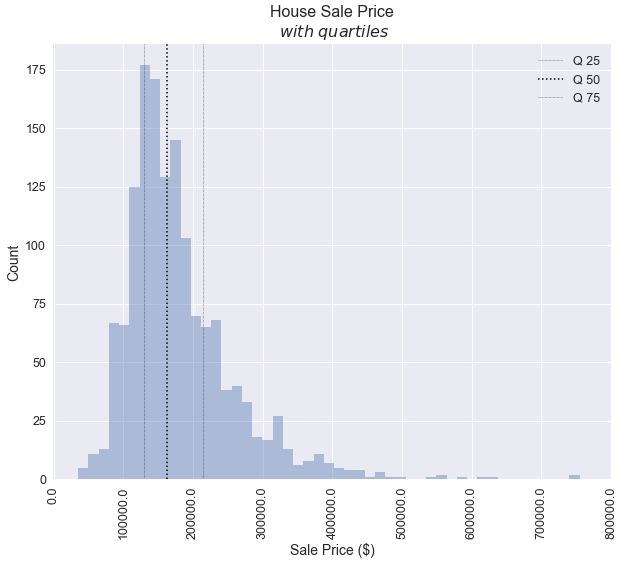

In [55]:
sns.distplot(train.SalePrice, kde=False)
plt.xticks(1e5*np.arange(9), 1e5*np.arange(9), rotation=90)
plt.xlabel('Sale Price ($)', fontsize='14')
plt.ylabel('Count', fontsize='14')
plt.title('House Sale Price\n $\it{with}$ $\it{quartiles}$', fontsize='16')
for i, x in enumerate([129975, 163000, 214000]): # enumerate returns the index (= i) and value (= x) in a list
    plt.axvline(x=x, color='k', lw=i%2+.5, ls='dotted', label="Q {}".format((i+1)*25)) 
    # 'lw=i%2+.5'makes the median line darker
plt.legend(loc='upper right')

Now that the outliers have been identified, they can be eliminated from the data.

In [56]:
from scipy import stats
# Removes observations lying outside of 3 standard deviations away from the mean SalePrice
train_NO = train[(np.abs(stats.zscore(train.SalePrice)) < 3)]

In [57]:
print("Number of Observations Removed: {}".format(len(train)-len(train_NO)))

Number of Observations Removed: 22


With the outliers eliminated, the distribution plot below should exhibit a more normal shape.

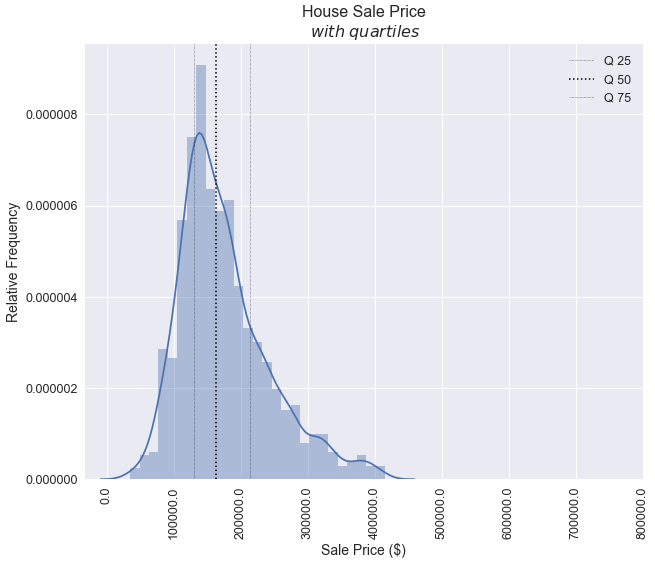

In [63]:
sns.distplot(train_NO.SalePrice)
plt.xticks(1e5*np.arange(9), 1e5*np.arange(9), rotation=90)
plt.xlabel('Sale Price ($)', fontsize='14')
plt.ylabel('Relative Frequency', fontsize='14')
plt.title('House Sale Price\n $\it{with}$ $\it{quartiles}$', fontsize='16')
for i, x in enumerate([129975, 163000, 214000]): # enumerate returns the index (= i) and value (= x) in a list
    plt.axvline(x=x, color='k', lw=i%2+.5, ls='dotted', label="Q {}".format((i+1)*25)) 
    # 'lw=i%2+.5'makes the median line darker
plt.legend(loc='upper right')

### Modeling

**1.  Linear Regression**

I begin my modeling with a standard linear regresssion. The data set still has a large number of features, so I do not expect it to be particularly accurate; however, it should serve as an adequate baseline upon which to improve.

In [64]:
train_xs = train_NO.drop(["SalePrice"], axis = 1) # removes the dependent variable from the data set

In [65]:
# Split the data into training and testing sets. 
X_train, X_test, y_train, y_test = train_test_split(train_xs, train_NO.SalePrice, test_size=0.33, random_state=42)

With many models, it is important to scale the data to avoid biasing the model. For example, some features like lot area or house square footage will be quite large, while others such as number of bathrooms will be much smaller; thus, their coefficients will have large discrepencies. Especially for methods of optimization like gradient descent, scaled data is crucial to model accuracy.

In [67]:
scaler = StandardScaler() # Initializes the StandardScaler function as 'scaler' 
scaler.fit(X_train) # Calculates means and standard deviations of data in order to fit a scaling function
scaled_xtrain = scaler.transform(X_train) # Uses previous calculations to transform data into a scaled dataframe

In [68]:
# Initializes the 'LinearRegression' model from SKLearn.
lin_reg = linear_model.LinearRegression()

In [69]:
# Trains the OLS model with the training subset data.
lin_reg.fit(scaled_xtrain, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [70]:
# Uses OLS model to predict 'SalePrice'
y_predict_OLS = lin_reg.predict(scaler.transform(X_test)) # ??? Need to 'scaler.fit(X_test)' ???

In [71]:
lin_reg.coef_ # Prints the coefficients of the linear regression model

array([ -4.22292733e+02,   4.16236133e+03,   1.77588853e+04,
         6.73026080e+03,   4.77219907e+03,  -5.32332475e+02,
         5.49806395e+03,   5.94564744e+03,   4.24301300e+03,
        -3.43441437e+03,  -1.85648684e+03,   1.97390608e+03,
         1.70452734e+04,   1.63877784e+04,   5.29730675e+03,
         1.34119326e+03,   2.02369623e+03,   5.70168599e+03,
         1.56815699e+03,   1.68517970e+03,   5.24938703e+03,
        -1.20343511e+03,   2.69860015e+03,   6.59108946e+03,
         3.61609765e+03,   3.56541638e+03,   4.99186152e+02,
         1.61614536e+03,  -5.74653667e+02,  -3.41480321e+16,
        -3.47048875e+16,  -3.85499689e+16,  -4.50348179e+16,
        -3.19303751e+16,   6.87074276e+03,   2.18590289e+03,
         4.70023737e+03,   2.42228948e+03,   8.85280485e+16,
         5.77601700e+16,   8.83055658e+16,  -3.54670945e+03])

The above coefficients are from the linear regression. Most of them are unreasonably large, which could indicate poor model specification or problems arising from how the data was cleaned. Additional models should provide further insight to this issue.

In [72]:
np.sqrt(mean_squared_error(y_test, y_predict_OLS))

25734.513251587377

In [73]:
r2_score(y_test, y_predict_OLS)

0.84755061520139652

The mean squared error is extremely large and the R-squared value is suspiciously high, which leads me to believe that the model overfit the data as a result of too many features. I will first trim down the number of features to see if that will improve the accuracy of my linear model.

**2.  Tuning the Linear Model with Lasso**

With such a large number of parameters, it is necessary to determine which are the most informative. Using a Lasso model, also known as L1 regularization, I can identify the most important parameters to use in my models by forcing the model to also minimize the absolute value of the coefficients. The weak independent variables will be forced to zero, while the relevant coefficients will remain. 

In [75]:
# After iterating through various alpha values, I found that 100 gave the best RMSE
lasso_lin_reg = linear_model.Lasso(alpha = 100)
lasso_lin_reg.fit(scaled_xtrain, y_train)

Lasso(alpha=100, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [76]:
lasso_lin_reg.score(scaled_xtrain, y_train) # add description/interpretation

0.82183172743926414

In [77]:
# Predicts 'SalePrice' using the x-test data set and lasso coefficients
y_predict_lasso = lasso_lin_reg.predict(scaler.transform(X_test))

In [78]:
np.sqrt(mean_squared_error(y_test, y_predict_lasso))

25564.962752951524

The root mean squared error from the lasso model is an improvement of about 200 relative to ordinary least squares. This is still a fairly large and disappointing RMSE, so I will continue to search for a better model.

In [79]:
lasso_lin_reg.coef_

array([  -259.48389603,   4040.44291725,  17782.68304116,   6491.88690314,
         4440.08202598,     -0.        ,   5084.32911885,   5221.07791478,
         3971.58286896,  -3051.88762797,  -1953.34916618,   1857.35250158,
        13870.3112132 ,  13925.83153331,   4982.86093024,   1383.35259693,
         1759.70750259,   5610.67053999,   1757.97676053,   1601.92012292,
         5406.34110121,   -736.91024482,   2621.36740836,   6931.17882049,
         3268.01957009,   3590.88308437,    465.94270723,   1556.12707332,
         -447.69411943,  -1631.47737242,    484.96687181,     -0.        ,
         1075.55812454,  -1415.54586459,   6192.81363193,     -0.        ,
         1921.10723752,    943.50669778,     -0.        ,   -321.74670401,
         3000.88220593,     -0.        ])

While still relatively large, these coefficients look much more normal than those from the previous linear regression. This is because the lasso specification places a restraint on the magnitude of the coefficients.

In [81]:
coef = pd.Series(lasso_lin_reg.coef_, index = X_train.columns)

In [82]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  
      str(sum(coef == 0)) + " variables")

Lasso picked 37 variables and eliminated the other 5 variables


Under this lasso model, 5 variables were forced to zero. Next, I will extract the 10 lasso coefficients with the largest magnitude to see if this subset of features can improve my model predictions.

In [83]:
top_10_coef = pd.concat([np.abs(coef).sort_values().tail(10)])

The following graph illustrates the relative magnitude of the top 10 coefficients. Notice that many of these coefficients are the same from the correlation map. This serves as a small verification that the models are working as they should by identifying the most predictive features.

Text(0,0.5,'Feature')

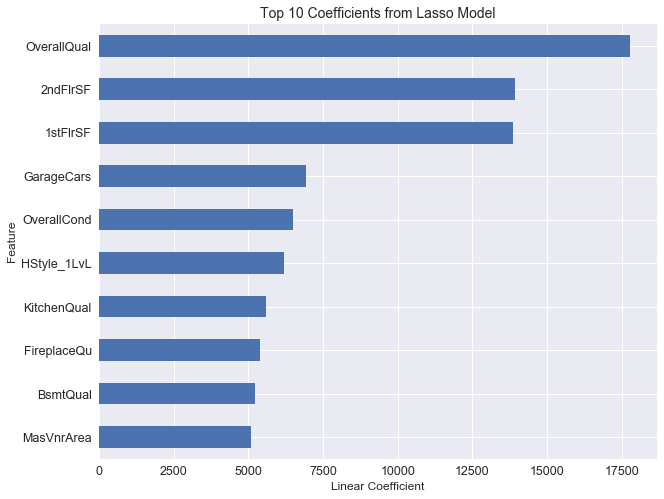

In [84]:
top_10_coef.plot(kind = "barh")
plt.title("Top 10 Coefficients from Lasso Model", fontsize=14)
plt.xlabel("Linear Coefficient", fontsize=12)
plt.ylabel("Feature", fontsize=12)

Just to check that the graph above is showing the correct coefficients and features, I will use another method of extracting the top 10 coefficients for corroberation. 

In [89]:
# Creates array of indices corresponding to the top 10 coefficients
np.abs(lasso_lin_reg.coef_).argsort()[::-1][:10]

array([ 2, 13, 12, 23,  3, 34, 17, 20,  7,  6])

In [90]:
# Creates array of top 10 coefficients by absolute value
top_10_Lcoefs_vals = lasso_lin_reg.coef_[np.abs(lasso_lin_reg.coef_).argsort()[::-1][:10]]

In [91]:
# Gets column names of top 10 columns from lasso
top_10_Lcoefs_names = train_xs.columns[np.abs(lasso_lin_reg.coef_).argsort()[::-1][:10]]

In [92]:
print("Feature","\t", "Coefficient")
for col, coef in zip(top_10_Lcoefs_names, top_10_Lcoefs_vals):
    print(col,"\t", coef)

Feature 	 Coefficient
OverallQual 	 17782.6830412
2ndFlrSF 	 13925.8315333
1stFlrSF 	 13870.3112132
GarageCars 	 6931.17882049
OverallCond 	 6491.88690314
HStyle_1LvL 	 6192.81363193
KitchenQual 	 5610.67053999
FireplaceQu 	 5406.34110121
BsmtQual 	 5221.07791478
MasVnrArea 	 5084.32911885


Hence, the two methods yield the same results; thus, confirming the validity of the identified top 10 features. 

Since the coefficients of the above features have the largest relative magnitudes, I will use them to make a new data subset and re-run my linear model. Hopefully, the accuracy will be improved.

In [93]:
# Creates new dataframes using only the top 10 features extracted with the Lasso regression
df_xtrain2 = pd.DataFrame(data=scaled_xtrain, columns=train_xs.columns)[top_10_Lcoefs_names]
df_xtest2 = pd.DataFrame(data=scaler.transform(X_test), columns=train_xs.columns)[top_10_Lcoefs_names]

In [94]:
df_xtrain2.head()

,OverallQual,2ndFlrSF,1stFlrSF,GarageCars,OverallCond,HStyle_1LvL,KitchenQual,FireplaceQu,BsmtQual,MasVnrArea
0,0.696682,-0.795086,0.710304,0.320413,-0.532307,0.984543,0.767856,-0.987319,0.591838,0.022961
1,-0.819486,-0.795086,-0.164534,0.320413,-0.532307,0.984543,-0.782344,-0.987319,1.774287,-0.592053
2,-0.061402,0.729983,-1.099978,0.320413,0.359192,-1.015700,-0.782344,0.677809,-0.590611,-0.592053
3,-0.061402,1.018822,-0.907619,0.320413,-0.532307,-1.015700,-0.782344,0.677809,0.591838,-0.592053
4,1.454765,-0.795086,0.886853,0.320413,-0.532307,0.984543,0.767856,1.232852,0.591838,-0.592053


In [95]:
lin_reg.fit(df_xtrain2, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [96]:
y_predict_OLS2 = lin_reg.predict(df_xtest2)

In [97]:
np.sqrt(mean_squared_error(y_test, y_predict_OLS2))

27743.740136045442

While this linear regression does not improve the root mean squared error of the original OLS regression, it achieves a relatively comparable RMSE with less than 25% of the features. This fact may indicate that this new model has a lower likelihood of overfitting. To verify that this model performs better out of sample, I will compare the training and testing RMSEs' of a model using both the original data and the new data frame (the 10 feature df derived from the lasso model). I expect that the model using fewer features will have training and test RMSEs that are closer together.

**3.  GridSearchCV with L1, L2, and Elasticnet Specifications**

The following model uses all of the features.

In [98]:
param_grid = {"penalty": ['l2','l1','elasticnet'], 'alpha':[.01, .1, .5, 1, 10], 
              "eta0": [ .001, .003, .01, .03, .1, .3, 1, 3], "tol": [.001, .0001]}
grid_search = GridSearchCV(linear_model.SGDRegressor(), param_grid, scoring='neg_mean_squared_error')

grid_search.fit(scaled_xtrain, y_train)
print("Best Parameters: {}".format(grid_search.best_params_))

Best Parameters: {'alpha': 1, 'eta0': 0.1, 'penalty': 'l2', 'tol': 0.001}


In [99]:
# Calculates train and test predictions using best estimator found during the grid search
y_predict_xtrain_all = grid_search.best_estimator_.predict(scaled_xtrain)
print("Train RMSE: {}".format(np.sqrt(mean_squared_error(y_train, y_predict_xtrain_all))))

y_predict_xtest_all = grid_search.best_estimator_.predict(scaler.transform(X_test))
print("Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_predict_xtest_all))))

Train RMSE: 32287.684119943115
Test RMSE: 26685.585603716543


The following model uses only the 10 features determined most important by the previous Lasso model.

In [100]:
param_grid = {"penalty": ['l2','l1','elasticnet'], 'alpha':[.01, .1, .5, 1, 10], 
              "eta0": [ .001, .003, .01, .03, .1, .3, 1, 3], "tol": [.001, .0001]}
grid_search = GridSearchCV(linear_model.SGDRegressor(), param_grid, scoring='neg_mean_squared_error')

grid_search.fit(df_xtrain2, y_train) # df_xtrain2, y_train
print("Best Parameters: {}".format(grid_search.best_params_))

Best Parameters: {'alpha': 0.1, 'eta0': 0.03, 'penalty': 'l2', 'tol': 0.0001}


In [101]:
# Calculates train and test predictions using best estimator found during the grid search
y_predict_xtrain_top10 = grid_search.best_estimator_.predict(df_xtrain2) # df_xtrain2
print("Train RMSE: {}".format(np.sqrt(mean_squared_error(y_train, y_predict_xtrain_top10))))

y_predict_xtest_top10 = grid_search.best_estimator_.predict(df_xtest2) # df_xtest2 = RMSE 40,473.7
print("Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_predict_xtest_top10))))

Train RMSE: 31596.27577622634
Test RMSE: 28460.630285747207


As expected, the model using only 10 features performs significantly better than the model using all of the original features in terms of variance. This confirms my suspicion that the original model with all of the features overfit the training data. However, the RMSE is still quite awful, so I will move on to other models in hopes of improving predictive accuracy.

**4.  K-Nearest Neighbors**

The K-Nearest Neighbors method of regression uses the relative distance from other observations to make predictions. In this case, the KNeighbors regressor will compare an observation on all the features and measure the "distance", or close-ness to the nearest k observations, then use a weighting of those observations to make a prediction of the sale price. 

In [103]:
from sklearn.neighbors import KNeighborsRegressor

In [104]:
kn_reg = KNeighborsRegressor()

The 'GridSearchCV' method is a way of tuning hyperparameters for a given model. Hyperparameters are model parameters that cannot be explicitly chosen by the model and must be picked by the user. For this model, the function tests the hyperparameters of 'number of neighbors', 'weights', and various p-norms (measures of distance).

In [106]:
gridsearchkn  = GridSearchCV(kn_reg, {"n_neighbors": [1, 3, 5, 7, 9, 11, 13], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring = 'neg_mean_squared_error')

In [107]:
gridsearchkn.fit(scaled_xtrain, y_train) # df_xtrain2 # scaled_xtrain

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13], 'weights': ['uniform', 'distance'], 'p': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [108]:
print("Best Parameters: {}".format(gridsearchkn.best_params_))

Best Parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


In [109]:
y_predictKN_xtrain = gridsearchkn.best_estimator_.predict(scaled_xtrain) # df_xtrain2 # scaled_xtrain
print("Train RMSE: {}".format(np.sqrt(mean_squared_error(y_train,y_predictKN_xtrain))))
y_predictKN_xtest = gridsearchkn.best_estimator_.predict(scaler.transform(X_test)) # df_xtest2 # scaler.transform(X_test)
print("Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_predictKN_xtest))))

Train RMSE: 189.12543981015685
Test RMSE: 26570.332274824672


The K-Nearest Neighbors Regressor gives the best root mean squared error on the training set thus far, but that is not saying much given the still very high RMSE for the test set.

### Conclusion

Overall, I would not trust my models to make any important decisions. However, this was a great learning experience and thoroughly enjoyed this homework. I was able to learn a lot just from this one kaggle competition. One thing that I think could be improved, is getting to modeling more quickly. I spent too much time cleaning the data, when I should have finished a baseline model and worked from there.

### Test Data

In [110]:
# Save test data IDs
test_ids = test.Id.to_frame()

In [111]:
test.drop(dropped, axis=1, inplace=True)

In [112]:
# Reduces 'Exterior1st' column to just have 5 categories: 'VinylSd', 'HdBoard', 'MetalSd', 'Wd Sdng', and 'Other'
test.Exterior1st = test.Exterior1st.apply(lambda x: x if str(x)[0]=="V" or str(x)[0]=="H" or str(x)[0]=="M" 
                                           or str(x)[0:5]=="Wd Sd" else "Other")
# Creates dummies for new Exterior1st column
test = pd.get_dummies(test, columns=["Exterior1st"])

In [113]:
# Since 80% of the values are either 1 or 2 story houses, the other values are extraneous and uninformative
# Hence, 'HouseStyle_1' essentially serves as an indicator for 1 story or more than 1 story (1.5, 2, 2.5, & split lvl)
test["HStyle_1LvL"] = np.where(test.HouseStyle.str.contains("1Story"), 1, 0)
test.drop("HouseStyle", axis=1, inplace=True)

In [114]:
# Encodes 'GarageFinish' column to an indicator for houses with finished garages instead of categories
test.GarageFinish = test.GarageFinish.apply(lambda x: 1 if str(x)[0:3] == "Fin" else 0)

In [115]:
# Reduces 'Foundation' column to just have 3 categories: 'PConc', 'CBrick', and 'Other'
test.Foundation = test.Foundation.apply(lambda x: x if str(x)[0] == "P" or str(x)[0] == "C" else "Other")

# Creates dummy variables for each Neighborhood
test = pd.get_dummies(test, columns=["Foundation"])

In [116]:
# Consolidates 'BrkFace' and 'BrkCmn' into one 'Brick' category
test.MasVnrType = test.MasVnrType.apply(lambda x: x if str(x)[0:3] != "Brk" else "Brick")

# Creates dummy variables for 'MasVnrType'
test = pd.get_dummies(test, columns=["MasVnrType"])

In [117]:
# Dictionary assigning numeric values to categorical columns with a "poor" to "excellent"
num_assignments = {"BsmtQual": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, np.nan:0},
                  "HeatingQC": {"Ex":4, "Gd":3, "TA":2, "Fa":1, "Po":0},
                  "KitchenQual": {"Ex":4, "Gd":3, "TA":2, "Fa":1, "Po":0},
                  "FireplaceQu": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, np.nan:0},
                  "BsmtFinType1": {"GLQ":6, "ALQ":5, "BLQ":4, "Rec":3, "LwQ":2, "Unf":1, np.nan:0}}
# Note: For 'BsmtQual', FireplaceQu', and 'BsmtFinType1' the null values are set to zero as their own category. 
        # This makes sense in context because the categories are measuring feature quality; Hence, if a feature is not
        # reported it cannot be characterized.
# Uses the 'num_assignments' dictionary to assign numeric values to the specified columns
test.replace(num_assignments, inplace=True)

In [118]:
# creates variable measuring total square feet of the house
test["TotalSqFt"] = test.TotalBsmtSF + test.GrLivArea
# TotalBsmtSF = Total square feet of basement area
# GrLivArea = Total above grade (ground) living area square feet

test.drop(["TotalBsmtSF", "GrLivArea"], axis=1, inplace=True)

**Imputing Null Values**

In [119]:
Nulls_cat = []
Nulls_noncat = []

print("Column\t\t", "Nulls\t", "dtype\t")
for i in test:
    if test[i].dtype=='object':
        if test[i].isnull().sum() != 0:
            print(i,"\t", test[i].isnull().sum(),"\t", test[i].dtype)# Prints sum of null values for columns containing nulls
            Nulls_cat.append(i)
    else:
        if test[i].isnull().sum() != 0:
            print(i,"\t", test[i].isnull().sum(),"\t", test[i].dtype)
            Nulls_noncat.append(i)

Column		 Nulls	 dtype	
LotFrontage 	 227 	 float64
MasVnrArea 	 15 	 float64
BsmtFinSF1 	 1 	 float64
BsmtUnfSF 	 1 	 float64
BsmtFullBath 	 2 	 float64
KitchenQual 	 1 	 float64
GarageYrBlt 	 78 	 float64
GarageCars 	 1 	 float64
GarageArea 	 1 	 float64
TotalSqFt 	 1 	 float64


In [120]:
set(X_train.columns).difference(set(test.columns))

set()

In [121]:
# Fills the numeric columns with null values (contained in the array "Nulls") with the column averages
test = test.fillna(train[Nulls_noncat].mean()).round()

In [122]:
predictions = gridsearchkn.best_estimator_.predict(test)

In [123]:
test_ids['SalePrice'] = predictions

In [125]:
(test_ids).head()

,Id,SalePrice
0,1461,263161.041326
1,1462,255550.689590
2,1463,293068.133183
3,1464,307972.111576
4,1465,263132.058314


In [ ]:
test_ids.to_csv('submission1.csv', index=False)